In [1]:
from torch import nn
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

#os and Files
import glob
import os

#Machine Learning
import tensorflow as tf

#PyTorch Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
print(torch.__version__)

#analytics
from torchsummary import summary
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

#Image Processing
from PIL import Image
from PIL import Image
from skimage.color import rgb2gray

#DataLoader and Augmentations
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from skimage.transform import*
from albumentations.pytorch import ToTensorV2
from albumentations import (Normalize, Compose, Resize, VerticalFlip, HorizontalFlip, ShiftScaleRotate,CropNonEmptyMaskIfExists, CLAHE)

#Data reading and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


#Misc.
import random
import time

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import torch.nn.functional as F
from einops import rearrange, repeat, reduce
from functools import partial

import logging

from typing import Optional, Mapping, Tuple, Union
from collections import defaultdict
import math
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tqdm.notebook import tqdm

import json
import cv2
import imageio
import os
import gc
import joblib
import psutil
import pickle

import imageio.v2 as imageio


2.1.2


In [2]:
# Source Shape
HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

# Target Shape is divisable by 64 as required by Mask-RCNN
HEIGHT_TARGET = 576
WIDTH_TARGET = 704
SHAPE_TARGET = (HEIGHT_TARGET, WIDTH_TARGET) 

In [3]:
# DataFrame Columns to be Saved, exclude annotations and bbox
DF_SAVE_COLUMNS = [
    'image_id',
    'cell_type',
    'width',
    'height',
    'file_name',
    'file_path',
    'annotation_id',
    'category_id',
    'area',
    'label',
    'instance_count',
]

In [4]:
print('Reading train.sjon...')
with open('livecell_coco_train.json', 'r') as f:
    train_annotations = json.load(f)

# VAL
print('Reading val.sjon...')
with open('livecell_coco_val.json', 'r') as f:
    val_annotations = json.load(f)

# TEST
print('Reading test.sjon...')    
with open('livecell_coco_test.json', 'r') as f:
    test_annotations = json.load(f)

Reading train.sjon...
Reading val.sjon...
Reading test.sjon...


In [5]:
df_rows = []

annotations = [train_annotations, val_annotations, test_annotations]
subsets = ['train', 'val', 'test']

for idx, (data, subset) in enumerate(zip(tqdm(annotations), subsets)):
    print(f'idx: {idx}, subset: {subset}')
    
    # Image Id to Image
    image_id2_image_dict = dict()
    for image in data['images']:
        image_id2_image_dict[image['id']] = image
    
    for annotation in tqdm(data['annotations']):
        image_id = annotation['image_id']
        image = image_id2_image_dict.get(image_id)
        # Image File Path
        file_name = image['file_name']
        cell_type = file_name.split('_')[0]
        if subset in ['train', 'val']:
            file_path = f'images/livecell_train_val_images/{file_name}'
        else:
            file_path = f'images/livecell_test_images/{file_name}'
        
        df_rows.append({
            'image_id': np.int32(image['id']),
            'cell_type': cell_type,
            'width': np.int16(image['width']),
            'height': np.int16(image['height']),
            'file_name': file_name,
            'file_path': file_path,
            'annotation_id': np.int32(annotation['id']),
            'category_id': np.int8(annotation['category_id']),
            'polygons': np.array(annotation['segmentation'], dtype=np.float32),
            'area': np.float32(annotation['area']),
            'bbox': np.array(annotation['bbox'], dtype=np.float32),
        })


  0%|          | 0/3 [00:00<?, ?it/s]

idx: 0, subset: train


  0%|          | 0/1018576 [00:00<?, ?it/s]

idx: 1, subset: val


  0%|          | 0/181610 [00:00<?, ?it/s]

idx: 2, subset: test


  0%|          | 0/462261 [00:00<?, ?it/s]

In [6]:
# Create pandas DataFrame
df = pd.DataFrame.from_dict(df_rows)

# Cast to Category to Reduce Memory Usage
df['file_name'] = df['file_name'].astype('category')
df['file_path'] = df['file_path'].astype('category')
df['cell_type'] = df['cell_type'].astype('category')

# CELL TYPES
CELL_TYPES = np.sort(df['cell_type'].unique())
print(f'CELL_TYPES: {CELL_TYPES}')

# Cell Type to Label Dictionary, "+ 1" sine 0 is reserved for background
CELL_TYPE2LABEL = dict([(name, i + 1) for i, name in enumerate(CELL_TYPES)])
df['label'] = df['cell_type'].apply(CELL_TYPE2LABEL.get).astype(np.int8)

CELL_TYPES: ['A172' 'BT474' 'BV2' 'Huh7' 'MCF7' 'SHSY5Y' 'SKOV3' 'SkBr3']


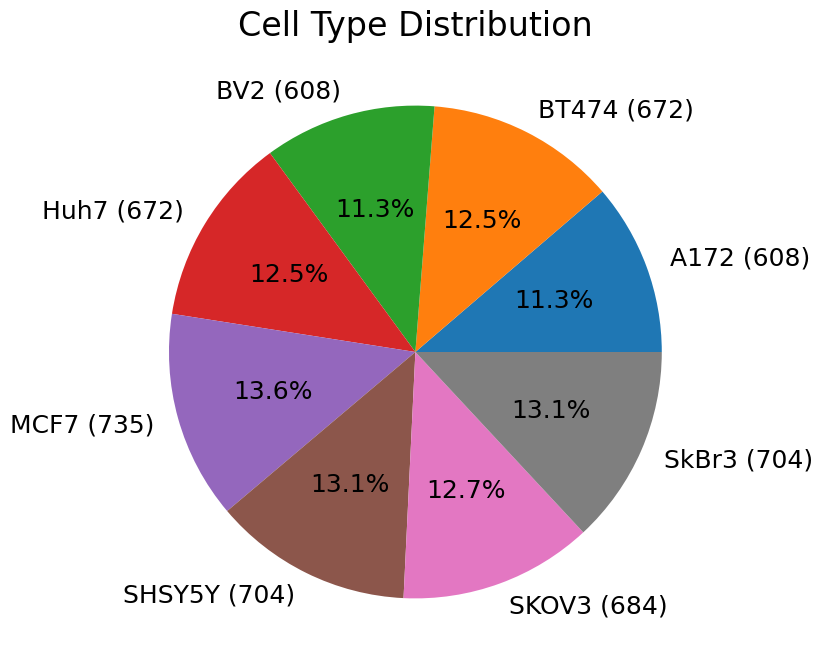

In [7]:
# Plot Distribution of Sample Cell Types
cell_type_labels = []
for cell_type, count in df.groupby('image_id')['cell_type'].first().value_counts().sort_index().items():
    cell_type_labels.append(f'{cell_type} ({count})')

plt.figure(figsize=(8, 8))
df.groupby('image_id')['cell_type'].first().value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%', labels=cell_type_labels, textprops={'fontsize': 18})
plt.title('Cell Type Distribution', size=24)
plt.ylabel('')
plt.show()

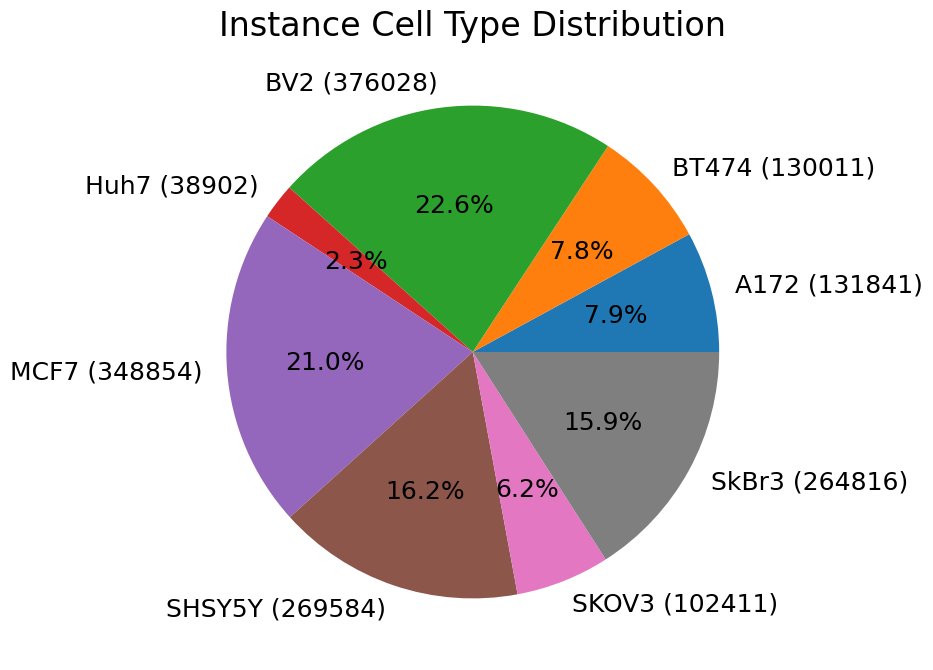

In [8]:
# Plot Distribution of Instances
instance_cell_type_labels = []
for cell_type, count in df['cell_type'].value_counts().sort_index().items():
    instance_cell_type_labels.append(f'{cell_type} ({count})')

plt.figure(figsize=(8, 8))
df['cell_type'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%', labels=instance_cell_type_labels, textprops={'fontsize': 18})
plt.title('Instance Cell Type Distribution', size=24)
plt.ylabel('')
plt.show()

In [9]:
# Plot Instance Distribtuion per Cell Type
instances_count_df = pd.DataFrame()
percentiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]

for cell_type in CELL_TYPES:
    instances_count_df[cell_type] = df[df['cell_type'] == cell_type].groupby('image_id')['image_id'].count().describe(percentiles=percentiles)

    
display(instances_count_df.T)

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
A172,608.0,216.843750,137.521148,1.0,60.07,70.0,78.0,98.75,173.0,313.25,425.0,481.60,589.79,656.0
BT474,672.0,193.468750,71.787808,1.0,101.13,113.0,121.0,141.00,179.0,227.00,286.9,341.25,418.06,540.0
BV2,608.0,618.467105,571.136258,2.0,57.77,87.0,99.7,147.75,392.5,1004.75,1461.4,1702.60,2274.23,3015.0
Huh7,672.0,57.889881,19.718883,21.0,27.71,32.0,36.0,44.00,55.0,67.00,81.0,93.45,115.58,190.0
MCF7,735.0,474.631293,351.943036,57.0,80.68,99.0,115.0,176.00,363.0,726.00,981.6,1179.60,1411.96,1522.0
SHSY5Y,704.0,382.931818,264.401444,1.0,75.03,103.3,125.3,166.75,304.0,534.50,774.4,882.70,1232.35,1422.0
SKOV3,684.0,149.723684,93.034029,21.0,35.49,46.0,55.0,76.00,125.0,207.00,281.0,320.70,437.02,554.0
SkBr3,704.0,376.159091,160.042252,1.0,167.00,189.0,208.0,255.00,345.5,463.25,565.7,642.85,990.31,1183.0


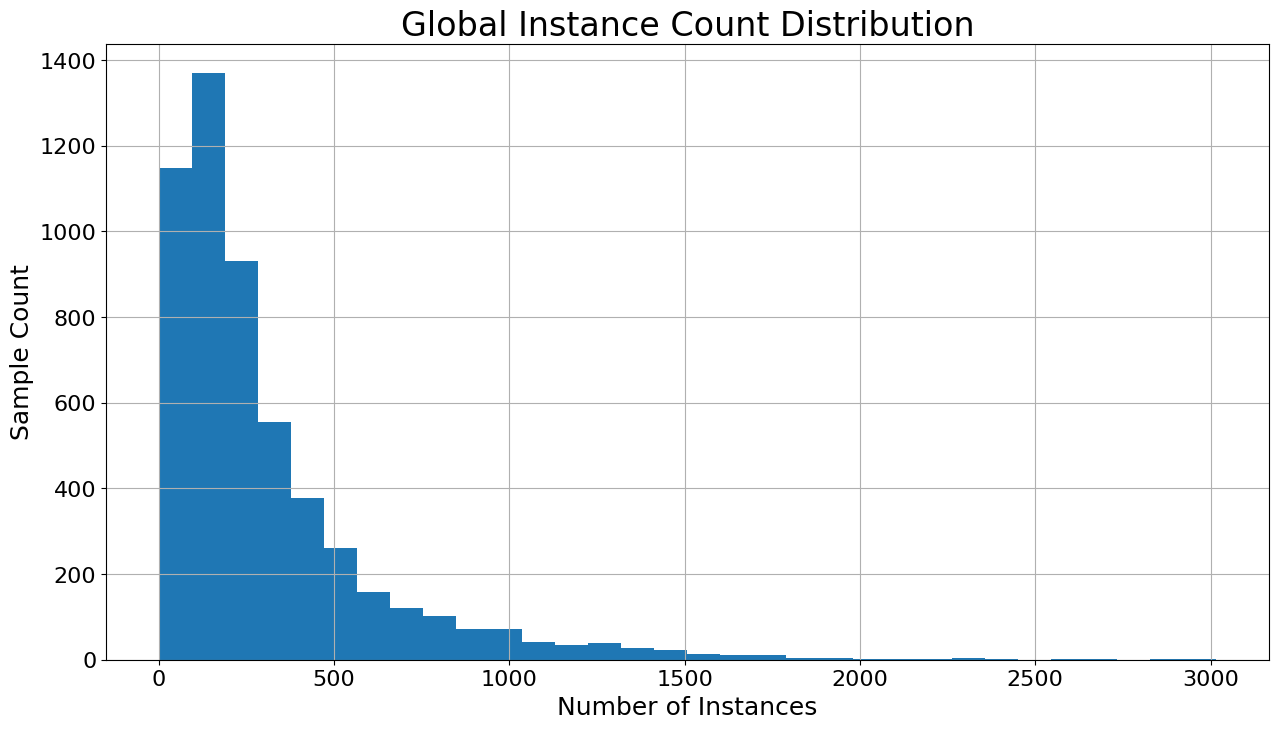

In [10]:
plt.figure(figsize=(15, 8))
df.groupby('image_id')['image_id'].count().plot(kind='hist', bins=32)
plt.title('Global Instance Count Distribution', size=24)
plt.xlabel('Number of Instances', size=18)
plt.ylabel('Sample Count', size=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.grid()
plt.show()

In [11]:
# Instance Count Percentiles
df.groupby('image_id')['image_id'].count().describe(percentiles=[0.95, 0.96, 0.97, 0.98, 0.99])

count    5387.000000
mean      308.603490
std       315.596823
min         1.000000
50%       203.000000
95%       970.000000
96%      1043.000000
97%      1160.680000
98%      1305.560000
99%      1522.140000
max      3015.000000
Name: image_id, dtype: float64

In [12]:
# Compute Instance Count
df['instance_count'] = df.groupby('image_id')['image_id'].transform('count').astype(np.uint16)

In [13]:
# Drop Image Ids with over 1000 instances
MAX_INSTANCE_COUNT = 1000
df.drop(df[df['instance_count'] > MAX_INSTANCE_COUNT].index, inplace=True)

# Reset Index
df.reset_index(inplace=True)

In [14]:
# Save DataFrame
df[DF_SAVE_COLUMNS].to_feather('df.feather', compression='zstd')

In [15]:
del df_rows
train_annotations.clear()
val_annotations.clear()
test_annotations.clear()
gc.collect()

6657679

In [16]:
display(df.head())

,index,image_id,cell_type,width,height,file_name,file_path,annotation_id,category_id,polygons,area,bbox,label,instance_count
0,0,1,BT474,704,520,BT474_Phase_A3_2_00d04h00m_3.tif,images/livecell_train_val_images/BT474_Phase_A...,2,1,"[[288.02, 305.63, 286.01, 298.87, 286.01, 295....",307.478607,"[286.01, 287.73, 19.17, 20.27]",2,130
1,1,1,BT474,704,520,BT474_Phase_A3_2_00d04h00m_3.tif,images/livecell_train_val_images/BT474_Phase_A...,3,1,"[[271.22, 323.34, 267.93, 322.61, 266.29, 320....",247.475555,"[263.0, 304.9, 20.45, 18.44]",2,130
2,2,1,BT474,704,520,BT474_Phase_A3_2_00d04h00m_3.tif,images/livecell_train_val_images/BT474_Phase_A...,4,1,"[[284.91, 279.88, 289.85, 281.52, 293.31, 281....",245.229446,"[275.42, 277.14, 23.92, 17.16]",2,130
3,3,1,BT474,704,520,BT474_Phase_A3_2_00d04h00m_3.tif,images/livecell_train_val_images/BT474_Phase_A...,5,1,"[[260.86, 327.64, 258.19, 325.63, 255.25, 324....",574.213074,"[246.96, 280.72, 20.99, 54.0]",2,130
4,4,1,BT474,704,520,BT474_Phase_A3_2_00d04h00m_3.tif,images/livecell_train_val_images/BT474_Phase_A...,6,1,"[[241.75, 324.69, 239.61, 326.97, 236.27, 331....",296.311401,"[229.45, 302.91, 22.59, 32.75]",2,130


In [17]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336866 entries, 0 to 1336865
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   index           1336866 non-null  int64   
 1   image_id        1336866 non-null  int32   
 2   cell_type       1336866 non-null  category
 3   width           1336866 non-null  int16   
 4   height          1336866 non-null  int16   
 5   file_name       1336866 non-null  category
 6   file_path       1336866 non-null  category
 7   annotation_id   1336866 non-null  int32   
 8   category_id     1336866 non-null  int8    
 9   polygons        1336866 non-null  object  
 10  area            1336866 non-null  float32 
 11  bbox            1336866 non-null  object  
 12  label           1336866 non-null  int8    
 13  instance_count  1336866 non-null  uint16  
dtypes: category(3), float32(1), int16(2), int32(2), int64(1), int8(2), object(2), uint16(1)
memory usage: 62.8+ MB


None

In [18]:
# Pad Image to Target Shape
def pad_image(image, constant_values):
    pad_h = (HEIGHT_TARGET - HEIGHT) // 2
    pad_w = (WIDTH_TARGET - WIDTH) // 2
    
    if len(image.shape) == 3:
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0,0)), constant_values=constant_values)
    else:
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), constant_values=constant_values)

In [19]:
# Converts the Polygon Annotations to a Binary Mask
def polygons2mask(polygons):
    polygons = np.array(polygons, dtype=np.int32).reshape(1, -1, 2)
    mask = np.zeros(shape=SHAPE, dtype=np.uint8)
    mask = cv2.fillPoly(mask, pts=polygons, color=255)
    
    return mask

In [20]:
# Converts a image_id to all masks of the corresponding image
def polygons_decode_by_image_id(image_id):
    mask_polygons = df.loc[df['image_id'] == image_id, 'polygons']
    n_masks = len(mask_polygons)
    
    # Image Shape
    mask = np.full(shape=[n_masks, *SHAPE], fill_value=0, dtype=np.uint8)
    
    for idx, polygons in enumerate(mask_polygons):
        mask[idx] = polygons2mask(polygons)
    
    mask = np.moveaxis(mask, 0, 2)
    
    return mask

In [21]:
# Create Padded Image, Padded Masks and Class Ids for given image_id
def process_image_id(image_id):
    # Make Directory
    if not os.path.exists(f'train/{image_id}'):
        os.mkdir(f'train/{image_id}')
    
    # Image
    image = imageio.imread(image_id2file_path.get(image_id))
    image = pad_image(image, 128)
    imageio.imwrite(f'train/{image_id}/{image_id}.png', image)
    
    # Instances Masks
    masks = polygons_decode_by_image_id(image_id)
    masks = pad_image(masks, 0)
    np.savez_compressed(f'train/{image_id}/{image_id}_masks.npz', v=masks)

    # Class Ids
    class_ids = np.full(shape=masks.shape[-1], fill_value=image_id2label.get(image_id))
    np.savez_compressed(f'train/{image_id}/{image_id}_class_ids.npz', v=class_ids)

In [22]:
# Image Id to File Path Dictionary
image_id2file_path = df[['image_id', 'file_path']].squeeze().set_index('image_id').squeeze().to_dict()

# Image Id to File Path Dictionary
image_id2label = df[['image_id', 'label']].squeeze().set_index('image_id').squeeze().to_dict()

In [23]:
# Use a Subset to Finish Notebook within 9 Hour Time Limit
SAMPLE_SUBSET = 4000

# Full Dataset
if SAMPLE_SUBSET is None:
    unique_image_ids = df['image_id'].unique()
# Random Sample of Subset
else:
    np.random.seed(42) #DF_SAVE_COLUMNSeed for reproducible results
    unique_image_ids = np.random.choice(df['image_id'].unique(), SAMPLE_SUBSET, replace=False)

print(f'Found {len(unique_image_ids)} unique image_ids')

Found 4000 unique image_ids


In [24]:
# Save Processed Sample DataFrame
df_processed = df[np.isin(df['image_id'], unique_image_ids)].copy(deep=True).reset_index(drop=True)

# Save DataFrame
df_processed[DF_SAVE_COLUMNS].to_feather('df_processed.feather', compression='zstd')

In [25]:
# Create Train Folder
if not os.path.exists('train'):
    os.mkdir('train')

# Process Images in Parallell
jobs = map(joblib.delayed(process_image_id), unique_image_ids)
_ = joblib.Parallel(
    n_jobs=psutil.cpu_count(logical=True),
    verbose=1,
    require='sharedmem',
)(jobs)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   33.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  5.3min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed: 11.9min finished


In [26]:
# Remove df to reduce memory usage
del df, df_processed
gc.collect()

2747

In [33]:
import sys
sys.path.append("Mask-RCNN-TF2-master")

from mrcnn.config import Config
from mrcnn import model as modellib, utils

from mrcnn.config import Config
from mrcnn import visualize

import mrcnn.utils as utils
import mrcnn.model as model

In [28]:
import tensorflow as tf

In [29]:
# Mask-RCNN Config
class CellConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    
    NAME = "cell"

    # Set batch size to 1.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 1
    
    # Number of Classes
    NUM_CLASSES = 1 + len(CELL_TYPES)

    # Image Dimensions
    IMAGE_MIN_DIM = HEIGHT_TARGET
    IMAGE_MAX_DIM = WIDTH_TARGET
    IMAGE_SHAPE = [HEIGHT_TARGET, WIDTH_TARGET, 3]
    IMAGE_RESIZE_MODE = 'none'
    
    BACKBONE = 'efficientnetv2-b3'

    # Training Structure
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    TOP_DOWN_PYRAMID_SIZE = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    # Regions of Interest
    PRE_NMS_LIMIT = 6000
    # Non Max Supression
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    # Instances
    MAX_GT_INSTANCES = 790
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 200
    
    # Thresholds
    RPN_NMS_THRESHOLD = 0.70        # IoU Threshold for RPN proposals and GT
    DETECTION_MIN_CONFIDENCE = 0.50 # Non-Background Confidence Threshold
    DETECTION_NMS_THRESHOLD = 0.30  # IoU Threshold for ROI and GT
    ROI_POSITIVE_RATIO = 0.33
    
    # Mini Mask
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (112, 112)
    MASK_SHAPE = (56, 56)
    
    # DO NOT train Batch Normalization because of small batch size
    # There are too few samples to correctly train the normalization
    TRAIN_BN = False
    
    # Learning Rate
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0
    N_WARMUP_STEPS = 2
    LR_SCHEDULE = True
    
    # Dataloader Queue Size (was set to 100 but resulted in OOM error)
    MAX_QUEUE_SIZE = 10
    
    # Cache Items
    CACHE = True
    
    DEBUG = False
    
    WORKERS = 0
    
    # Losses
    LOSS_WEIGHTS = {
        'rpn_class_loss': 1.0,    # is the class of the bbox correct? / RPN anchor classifier loss (Forground/Background)
        'rpn_bbox_loss': 1.0,     # is the size of the bbox correct? / RPN bounding box loss graph (bbox of generic object)
        'mrcnn_class_loss': 1.0,  # loss for the classifier head of Mask R-CNN (Background / specific class)
        'mrcnn_bbox_loss': 1.0,   # is the size of the bounding box correct or not? / loss for Mask R-CNN bounding box refinement
        'mrcnn_mask_loss': 1.0,   # is the class correct? is the pixel correctly assign to the class? / mask binary cross-entropy loss for the masks head
    }
    
config = CellConfig()
config.display()


Configurations:
BACKBONE                       efficientnetv2-b3
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CACHE                          True
COMPUTE_BACKBONE_SHAPE         None
DEBUG                          False
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  704
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  576
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [704 704   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'm

In [30]:
# Dataset to Load Samples: image, masks and class_ids
class CellDataset(utils.Dataset):

    def load_data(self, image_ids, form, image_group):
        self.image_group = image_group
   
        for i, name in enumerate(CELL_TYPES):
            self.add_class('cell', 1 + i, name)
       
        # Add the image using the base method from utils.Dataset
        for vertical_flip in [True, False]:
            for horizontal_flip in [True, False]:
                for image in tqdm(image_ids):
                    self.add_image('cell', 
                            image_id=image, 
                            path=(f'./{image_group}/{image}/{image}.png'),
                            label = image_id2label.get(image),
                            height=512, width=512,
                            vertical_flip=vertical_flip, horizontal_flip=horizontal_flip,
                        )
            
            
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
    
        info = self.image_info[image_id]
        image_id = info['id']
    
        masks = np.load(f'./{self.image_group}/{image_id}/{image_id}_masks.npz')['v']

        class_ids = np.load(f'./{self.image_group}/{image_id}/{image_id}_class_ids.npz')['v']
        
        return masks, class_ids

In [31]:
# Load Dataset
dataset = CellDataset()
dataset.load_data(unique_image_ids, 'png', 'train')
dataset.prepare()


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [34]:
# Make Generator of Dataset
data_generator = model.DataGenerator(dataset, config, shuffle=True)

AttributeError: module 'mrcnn.model' has no attribute 'DataGenerator'